<a href="https://colab.research.google.com/github/wangdaming155/dive-into-deep-learning2/blob/main/%E9%A2%84%E6%B5%8B%E6%88%BF%E4%BB%B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
import os
os.chdir('/content/drive/MyDrive/d2l-zh')

In [64]:
import hashlib
import os
import tarfile
import zipfile
import requests


DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [65]:
def download(name, cache_dir=os.path.join('..', 'data')):  
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [66]:
def download_extract(name, folder=None):  
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [67]:
%matplotlib inline
import pandas as pd
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l


In [68]:
DATA_HUB['kaggle_house_train'] = (  
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [69]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [70]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [71]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [72]:
#在这里将train-data和test_data合二为一，按照前后顺序
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

先将所有的数据变为符合均值为0，方差为1 的数据，这样方便后面将啥也没有的数据也变为0，在同一水平进行处理

In [73]:
#数据预处理
# 无法获得数据，根据均值和平方差计算
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x:(x-x.mean())/(x.std())
)
all_features[numeric_features]= all_features[numeric_features].fillna(0)


处理离散值的时候，我们要注意将不同的离散值进行展开，同时，对于NA的数据我们可以单独列出来进行处理
```

# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape
```




In [74]:
all_features = pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(2919, 331)

In [75]:
# 从pandas 中将数据提取成numpy格式，并转换为tensor
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype = torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype = torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1),dtype = torch.float32)

## 训练

In [76]:
#模型确定，模型参数
#损失函数，优化算法

In [85]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
  net = nn.Sequential(nn.Linear(in_features,20),
  nn.ReLU(),
  nn.Linear(20, 1))
  return net


In [78]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [79]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [80]:
## k交叉验证

def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part    #没有的时候，赋值给训练集，如果没有这个，无法进行连接，所以记住赋值问题，然后有了，就连接
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [81]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0    #用来计算误差
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.080340, 验证log rmse0.168335
折2，训练log rmse0.095496, 验证log rmse0.177306
折3，训练log rmse0.084368, 验证log rmse0.204073
折4，训练log rmse0.073474, 验证log rmse0.163255
折5，训练log rmse0.099125, 验证log rmse0.171305
5-折验证: 平均训练log rmse: 0.086560, 平均验证log rmse: 0.176855


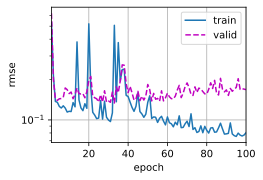

In [86]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [87]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()  #同时将tensor变为numpy
    print(preds)   #这里的net是线性回归网络，return的就是label
    print(pd.Series(preds.reshape(1, -1)[0]))
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0]) 
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.097948
[[124851.35]
 [170387.06]
 [180714.23]
 ...
 [170502.3 ]
 [123642.16]
 [222304.86]]
0       124851.351562
1       170387.062500
2       180714.234375
3       201962.078125
4       187534.609375
            ...      
1454     76116.562500
1455     80070.148438
1456    170502.296875
1457    123642.156250
1458    222304.859375
Length: 1459, dtype: float32


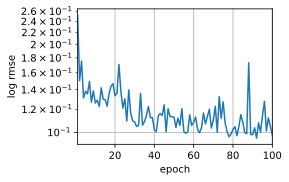

In [88]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)